In [25]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from tqdm import tqdm

data = pd.read_csv('data/mpst_full_data.csv')
data = data.drop_duplicates(subset='plot_synopsis')
data.head(2)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb


In [26]:
data["tag_count"] = data["tags"].apply(lambda text: len(str(text).split(", ")))
data.head(2)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tag_count
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,5
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1


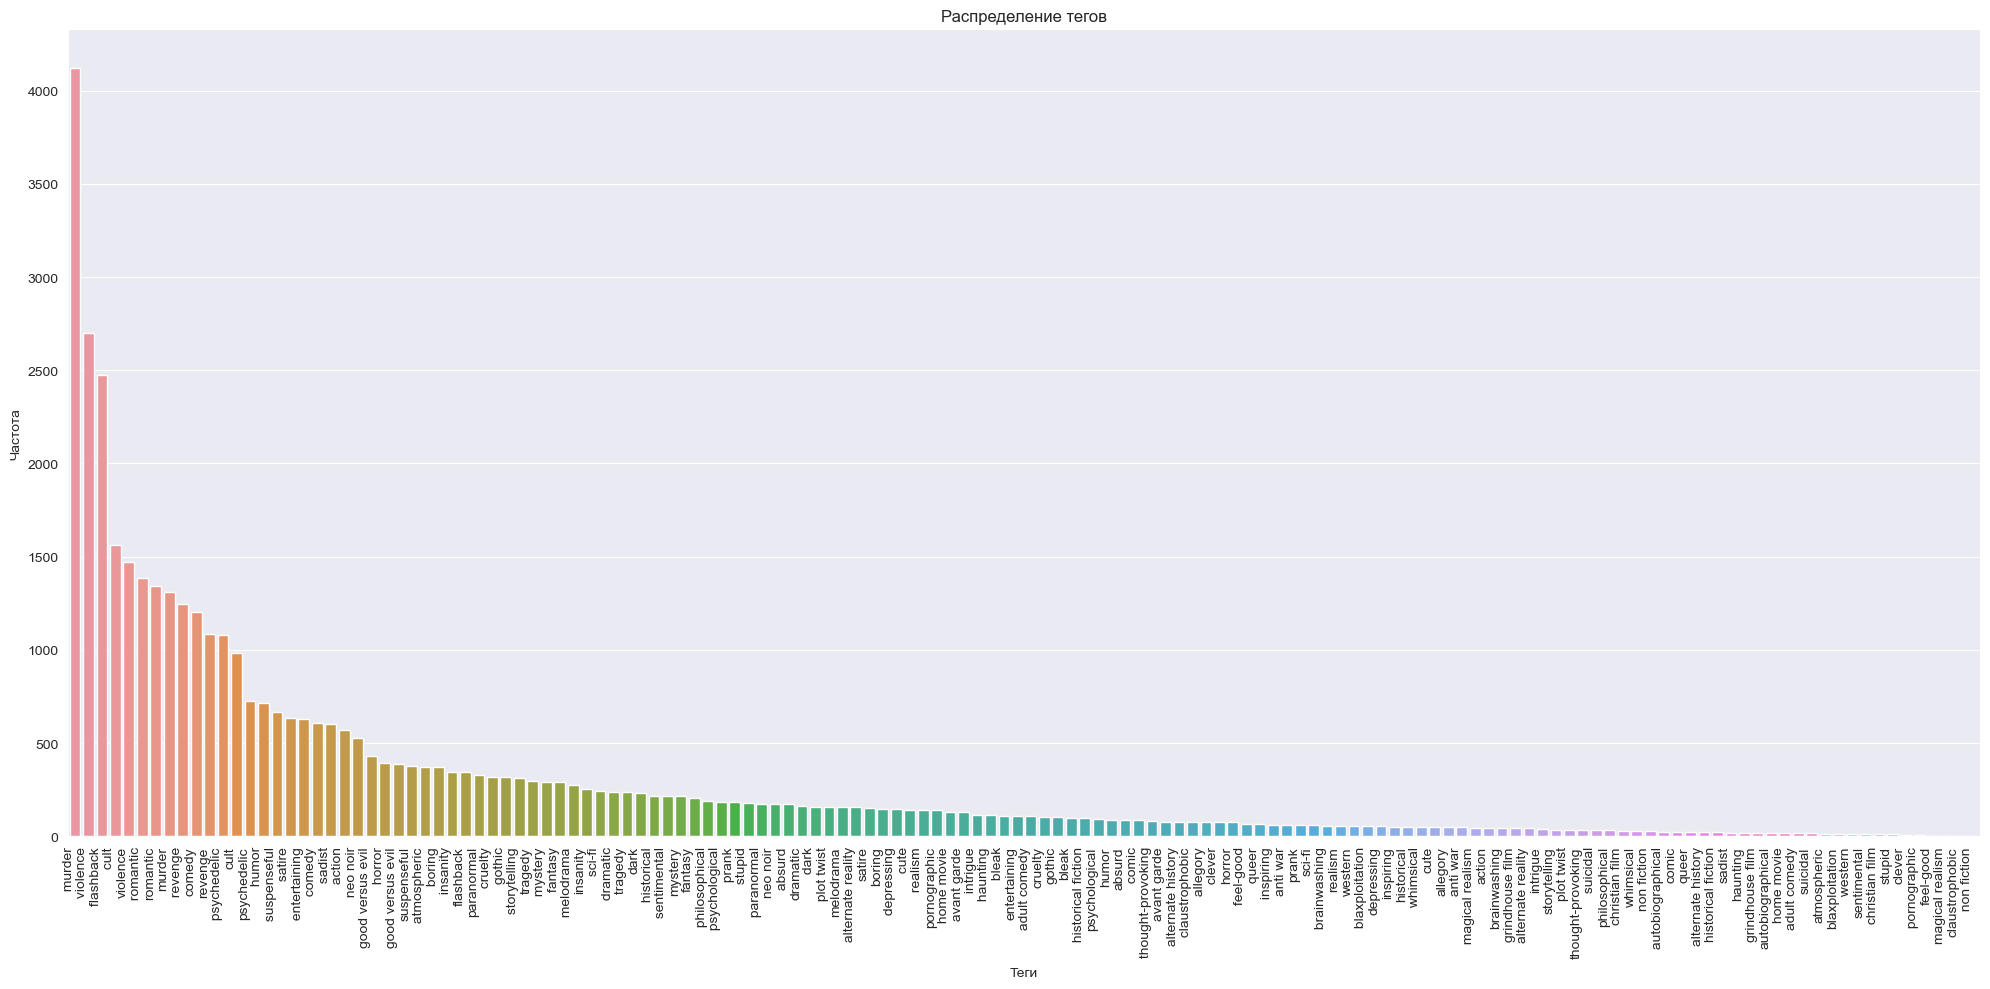

In [27]:
tag_counts = data['tags'].str.split(',').explode().value_counts()

plt.figure(figsize=(20, 10))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.title('Распределение тегов')
plt.xlabel('Теги')
plt.ylabel('Частота')

plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.tight_layout()
plt.show()

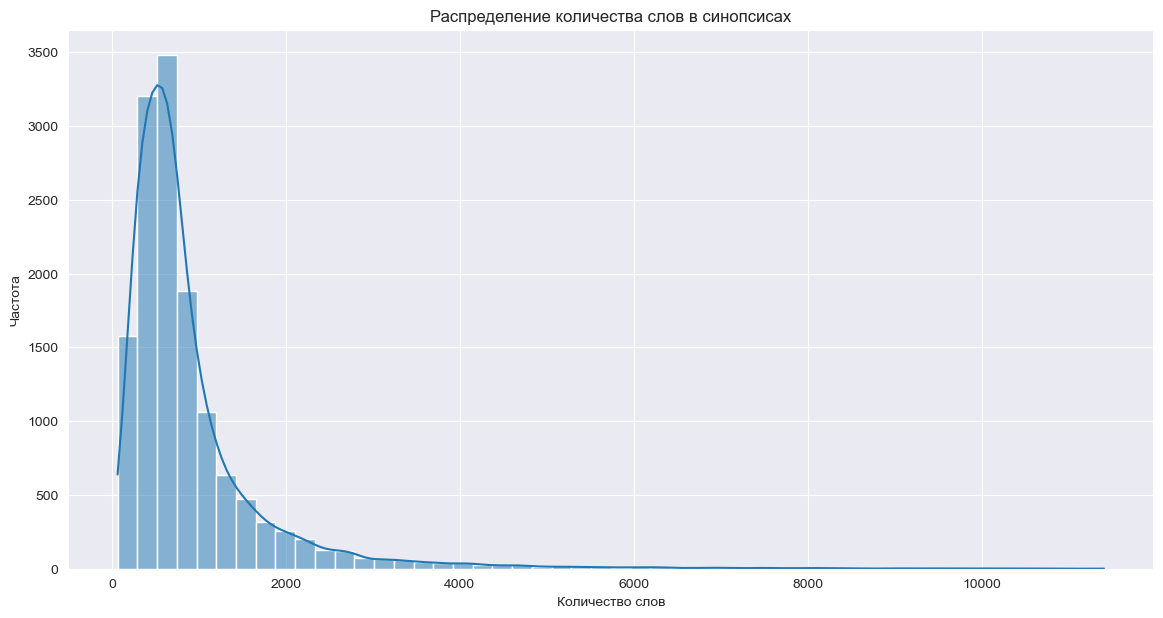

In [28]:
data['word_count'] = data['plot_synopsis'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 7))
sns.histplot(data['word_count'], bins=50, kde=True)
plt.title('Распределение количества слов в синопсисах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

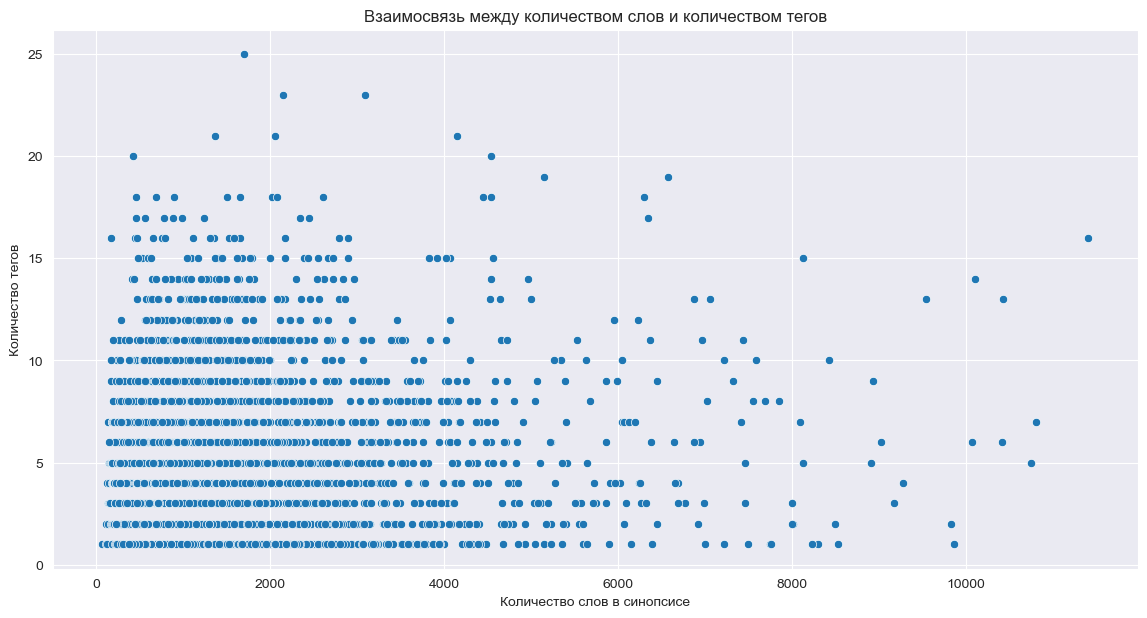

In [29]:
plt.figure(figsize=(14, 7))
data['tag_count'] = data['tags'].apply(lambda x: len(x.split(',')))
sns.scatterplot(x=data['word_count'], y=data['tag_count'])
plt.title('Взаимосвязь между количеством слов и количеством тегов')
plt.xlabel('Количество слов в синопсисе')
plt.ylabel('Количество тегов')
plt.show()

### Обработка текста

In [30]:
def expand_contractions(text):
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }

    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

    return text

In [31]:
stop_words = set(nltk_stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()


def process_synopsis(synopsis, stop_words, stemmer, lemmatizer):
    synopsis = re.sub(r"http\S+", "", synopsis)
    synopsis = BeautifulSoup(synopsis, 'lxml').get_text()
    synopsis = expand_contractions(synopsis)
    synopsis = re.sub(r"\S*\d\S*", "", synopsis).strip()
    synopsis = re.sub(r'[^A-Za-z]+', ' ', synopsis)

    processed_words = [
        stemmer.stem(lemmatizer.lemmatize(word.lower())).encode('utf8')
        for word in synopsis.split() if word.lower() not in stop_words
    ]

    return b' '.join(processed_words)

In [32]:
cleaned_synopses = [
    process_synopsis(synopsis, stop_words, stemmer, lemmatizer)
    for synopsis in tqdm(data['plot_synopsis'].values)
]

data['cleaned_synopsis'] = cleaned_synopses
data['cleaned_synopsis'] = data['cleaned_synopsis'].str.decode("utf-8")
data.head(4)

100%|██████████| 13848/13848 [02:14<00:00, 102.79it/s]


,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tag_count,word_count,cleaned_synopsis
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,5,1315,note synopsi orgin italian releas segment cert...
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1,378,two thousand year ago nhagruul foul sorcer rev...
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,1,707,matuschek gift store budapest workplac alfr kr...
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,4,2317,glenn holland morn person anyon standard woken...


In [33]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['tags'].apply(lambda x: x.split(', ')))

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(data['cleaned_synopsis'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Модели

In [34]:
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "Multinomial Naive Bayes": OneVsRestClassifier(MultinomialNB()),
    "Support Vector Classifier": OneVsRestClassifier(SVC(kernel='linear', probability=True)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier()),
    "K-Nearest Neighbors": OneVsRestClassifier(KNeighborsClassifier())
}

### Подбор гиперпараметров

In [35]:
param_grid_lr = {
    'estimator__C': [0.1, 1, 10],
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

grid_search_lr = GridSearchCV(models["Logistic Regression"], param_grid_lr, scoring='f1_micro', cv=3)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

In [ ]:
param_grid_rf = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20]
}

grid_search_rf = GridSearchCV(models["Random Forest"], param_grid_rf, scoring='f1_micro', cv=3)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

models["Logistic Regression"] = best_lr
models["Random Forest"] = best_rf

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')

    return accuracy, f1, precision, recall

### Обучение и оценка моделей 

In [ ]:
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)

    accuracy, f1, precision, recall = evaluate_model(model, X_test, y_test)

    results[model_name] = {
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall
    }

for model_name, metrics in results.items():
    print(f"\\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

### Выбор лучшей модели

В данном случае основная метрика F1-score, так как она учитывает как точность модели (precision), так и её полноту (recall), что делает её более подходящей для оценки качества модели на несбалансированных данных.

In [ ]:
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model_metrics = results[best_model_name]

print(f"\\nBest Model: {best_model_name}")
for metric_name, value in best_model_metrics.items():
    print(f"{metric_name}: {value:.4f}")

### Word2Vec

In [ ]:
sentences = [synopsis.split() for synopsis in data['cleaned_synopsis']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


def vectorize_text(text, model):
    words = text.split()
    vector = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
    return vector


X_w2v = np.array([vectorize_text(text, w2v_model) for text in data['cleaned_synopsis']])

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

### Обучение и оценка на данных Word2Vec

In [ ]:
results_w2v = {}

for model_name, model in models.items():
    print(f"Training {model_name} on Word2Vec data...")
    model.fit(X_train_w2v, y_train_w2v)

    accuracy, f1, precision, recall = evaluate_model(model, X_test_w2v, y_test_w2v)

    results_w2v[model_name] = {
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall
    }

for model_name, metrics in results_w2v.items():
    print(f"\\nModel (Word2Vec): {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

### Выбор лучшей модели для Word2Vec

In [ ]:
best_model_name_w2v = max(results_w2v, key=lambda x: results_w2v[x]['f1_score'])
best_model_metrics_w2v = results_w2v[best_model_name_w2v]

print(f"\\nBest Model (Word2Vec): {best_model_name_w2v}")
for metric_name, value in best_model_metrics_w2v.items():
    print(f"{metric_name}: {value:.4f}")